In [1]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'Biased Sampling'))

In [2]:
import pandas as pd

from XGB import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer
from stealthy_sampling import *

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
data = pd.read_csv('../../../Dataset/Kaggle-data.csv')
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data = data.drop(columns=['ID', 'Unnamed: 57'])
protected_feature = 'Subsystem'

data = data.dropna(axis=0)
data.head()

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.


,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,BaseOfData,...,ResourcesNb,ResourcesMeanEntropy,ResourcesMinEntropy,ResourcesMaxEntropy,ResourcesMeanSize,ResourcesMinSize,ResourcesMaxSize,LoadConfigurationSize,VersionInformationSize,legitimate
0,224,8450,8.0,0,16896,8192,0,16947,4096,24576,...,1,3.492126,3.492126,3.492126,864.0,864.0,864,72,0,1
1,224,258,9.0,0,84480,25600,0,10973,4096,90112,...,1,3.486827,3.486827,3.486827,892.0,892.0,892,72,0,1
2,224,8450,8.0,0,4608,3584,0,6452,4096,12288,...,1,3.517270,3.517270,3.517270,952.0,952.0,952,72,0,1
3,224,8450,10.0,0,108544,15872,0,105021,4096,114688,...,2,3.270559,3.034188,3.506931,1032.0,972.0,1092,72,0,1
4,224,8226,48.0,0,513024,2048,0,520922,8192,524288,...,1,3.420977,3.420977,3.420977,954.0,954.0,954,0,0,1


In [4]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='legitimate',
        protected_feature=protected_feature,
        do_scaling=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling only continuous numerical features (excluding heuristic categoricals and protected feature by default).
Features actually being scaled: ['SizeOfOptionalHeader', 'Characteristics', 'MajorLinkerVersion', 'SizeOfCode', 'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode', 'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion', 'MajorImageVersion', 'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfHeaders', 'CheckSum', 'SizeOfStackReserve', 'SectionsNb', 'SectionsMeanRawsize', 'SectionsMinRawsize', 'ImportsNb', 'ExportNb', 'ResourcesNb', 'ResourcesMeanEntropy', 'ResourcesMeanSize', 'LoadConfigurationSize', 'VersionInformationSize']


In [5]:
print(len(x_train.columns))
x_train.head()

29


,SizeOfOptionalHeader,Characteristics,MajorLinkerVersion,SizeOfCode,SizeOfInitializedData,SizeOfUninitializedData,AddressOfEntryPoint,BaseOfCode,ImageBase,SectionAlignment,...,SectionsNb,SectionsMeanRawsize,SectionsMinRawsize,ImportsNb,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMeanSize,LoadConfigurationSize,VersionInformationSize
23720,-0.305154,0.485687,0.033611,-0.004386,-0.019331,-0.017655,-0.011831,-0.008912,-0.005751,-0.006757,...,0.038719,-0.014858,-0.059186,-0.146148,-0.079959,-0.151470,-0.200632,-0.007894,-0.020052,-0.977947
76198,-0.305154,-0.559387,-0.036640,-0.019715,-0.015673,-0.017626,-0.019790,-0.008912,-0.005751,-0.006757,...,0.038719,-0.021930,-0.060777,0.380521,-0.091228,-0.062156,0.788055,-0.006975,-0.020054,-0.977947
26039,-0.305154,-0.561048,0.021903,-0.020603,-0.019977,-0.017648,-0.019970,-0.008912,-0.005751,-0.006757,...,0.437017,-0.024194,-0.060777,-0.292445,-0.091228,-0.144027,0.389231,-0.007935,-0.020052,-0.977947
201594,-0.305154,-0.561048,0.010194,-0.019520,-0.005840,-0.017419,-0.019684,-0.008912,-0.005751,-0.006757,...,0.437017,-0.020145,-0.060777,0.424410,-0.091228,-0.002613,-0.255934,-0.006457,-0.020054,-0.977947
211321,-0.305154,-0.561048,0.010194,-0.014633,-0.007843,-0.017655,-0.016655,-0.008912,-0.005751,-0.006757,...,0.038719,-0.009999,-0.030535,0.007464,-0.091228,0.004829,2.330882,-0.004251,-0.020053,0.762113


Accuracy: 0.9722675869719286
Precision: 0.9722288758935483
Recall: 0.9722675869719286
F-1: 0.9722361767935748


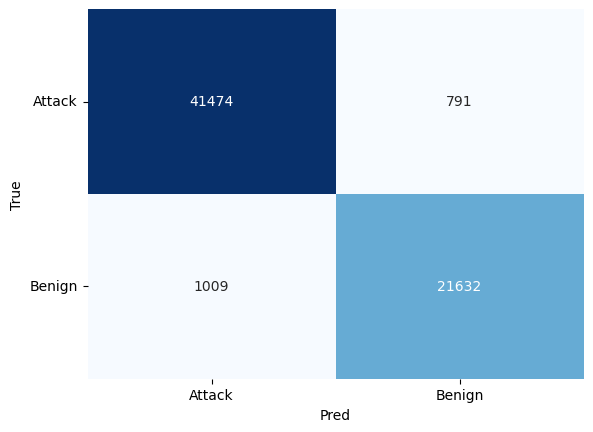

In [6]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

In [ ]:
# Pass the DataFrame to the attacker class to maintain feature names for plotting
attacker = AdversarialSHAPBackgroundAttack(
        model=model,
        X_train=x_train,
        sensitive_feature_name=protected_feature,
        sensitive_feature_index=list(x_train.columns).index(protected_feature),
        explainer_type='kernel',
        background_size=200,
        lambda_reg=1e-4,
        gamma_entropy=1e-7
    )

In [8]:
biased_weights, before, after = attacker.run_attack()
attacker.plot_shap_comparison(before, after)

Running attack with TreeExplainer...


[22:58:50] WARNING: C:\b\abs_0fh_d4x2ng\croot\xgboost-split_1713973188995\work\cpp_src\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


ExplainerError: Additivity check failed in TreeExplainer! Please ensure the data matrix you passed to the explainer is the same shape that the model was trained on. If your data shape is correct then please report this on GitHub. This check failed because for one of the samples the sum of the SHAP values was -4.007535, while the model output was -4.005844. If this difference is acceptable you can set check_additivity=False to disable this check.

In [ ]:
print(f"Sensitive feature '{protected_feature}' importance before attack: {before[attacker.sensitive_feature_index]:.4f}")
print(f"Sensitive feature '{protected_feature}' importance after attack: {after[attacker.sensitive_feature_index]:.4f}")
    
change = after[attacker.sensitive_feature_index] - before[attacker.sensitive_feature_index]
pct_change = (change / before[attacker.sensitive_feature_index] * 100) if before[attacker.sensitive_feature_index] != 0 else float('inf')
print(f"Change in importance: {change:.4f} ({pct_change:.2f}%)")

Sensitive feature 'has_failed_logins' importance before attack: -0.0003
Sensitive feature 'has_failed_logins' importance after attack: -0.0018
Change in importance: -0.0015 (540.36%)
